In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os
from os import listdir


import tensorflow as tf

import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages

In [3]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [5]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [6]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)

    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('track_jetp = sqrt(track_jetpx*track_jetpx + track_jetpy*track_jetpy + track_jetpz*track_jetpz)', inplace=True)
    temp.eval('track_jeteta = arctanh(track_jetpz/track_jetp)',inplace=True)
    temp.eval('track_jetpt = sqrt(track_jetpx*track_jetpx + track_jetpy*track_jetpy)', inplace=True)
    temp.eval('track_jetqt = sqrt( (e_px+track_jetpx)**2 + (e_py+track_jetpy)**2)',inplace=True)
    temp.eval('track_jetqtnorm = track_jetqt/sqrt(Q2)',inplace=True)
    
    
    temp.eval('track_jetqty = e_py+track_jetpy',inplace=True)
    temp.eval('track_jetqtx = e_px+track_jetpx',inplace=True)
    temp.eval('track_jetphiq = arctan(track_jetqty/track_jetqtx)',inplace=True)
    
    
    temp.eval('track_p=sqrt(track_px*track_px+track_py*track_py + track_pz*track_pz)',inplace=True)
    temp.eval('track_pt=sqrt(track_px*track_px + track_py*track_py)',inplace=True)
    
    temp.eval('track_jy = (track_jetpx*track_py - track_jetpy*track_px)/track_jetpt',inplace=True)
    temp.eval('track_jx = 1/(track_jetp*track_jetpt)*(track_px*track_jetpx*track_jetpz + track_py*track_jetpy*track_jetpz - track_pz*track_jetpt*track_jetpt)',inplace=True)
    temp.eval('track_phih = arctan(track_jy/track_jx)',inplace=True)
    temp.eval('track_dphi = track_jetphiq - track_phih', inplace=True)
    
    temp = applyCut(temp, '0.08 < y < 0.7', '0.08 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'pass_reco==0 | track_pt>0.200', 'track pT >200 MeV')
    temp = applyCut(temp, 'pass_reco==0 | track_jetpt>5.0', 'jet pT > 5 GeV')

    
    #temp = applyCut(temp, 'e_pt>15', 'e_pt >15')
    #temp = applyCut(temp, 'jet_pt>10', 'jet_pt>10')
   # temp = applyCut(temp, 'isBKG<1.0', 'isBKG')

    #temp = applyCut(temp, 'jet_qt<5', 'jet_qt<5')

    #temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'pass_reco==0 or track_jetpt >10.0', ' jet pt>10.0')
    
    #temp.eval('dphi = 3.14159-jet_dphi', inplace=True)
    #temp.eval('jet_qtnormjetpt= jet_qt/jet_pt', inplace=True)
    #temp.eval('jet_qtnormept= jet_qt/e_pt', inplace=True)
    if(isMC):
        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)
        temp.eval('gen_track_jetp = sqrt(gen_track_jetpx*gen_track_jetpx + gen_track_jetpy*gen_track_jetpy + gen_track_jetpz*gen_track_jetpz)', inplace=True)
        temp.eval('gen_track_jeteta = arctanh(gen_track_jetpz/gen_track_jetp)',inplace=True)

        
        temp.eval('gen_track_jetpt = sqrt(gen_track_jetpx*gen_track_jetpx + gen_track_jetpy*gen_track_jetpy)', inplace=True)
        temp.eval('gen_track_jetqt = sqrt( (gene_px+gen_track_jetpx)**2 + (gene_py+gen_track_jetpy)**2)',inplace=True)
        temp.eval('gen_track_jetqtnorm = gen_track_jetqt/sqrt(gen_Q2)',inplace=True)
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)

        temp.eval('gen_track_jy = (gen_track_jetpx*gen_track_py - gen_track_jetpy*gen_track_px)/gen_track_jetpt',inplace=True)
        temp.eval('gen_track_jx = 1/(gen_track_jetp*gen_track_jetpt)*(gen_track_px*gen_track_jetpx*gen_track_jetpz + gen_track_py*gen_track_jetpy*gen_track_jetpz - gen_track_pz*gen_track_jetpt*gen_track_jetpt)',inplace=True)
        temp.eval('gen_track_phih = arctan(gen_track_jy/gen_track_jx)',inplace=True)
    
        temp.eval('gen_track_jetqty = gene_py+gen_track_jetpy',inplace=True)
        temp.eval('gen_track_jetqtx = gene_px+gen_track_jetpx',inplace=True)
        temp.eval('gen_track_jetphiq = arctan(gen_track_jetqty/gen_track_jetqtx)',inplace=True)

        temp.eval('gen_track_p=sqrt(gen_track_px*gen_track_px+gen_track_py*gen_track_py + gen_track_pz*gen_track_pz)',inplace=True)
        temp.eval('gen_track_pt=sqrt(gen_track_px*gen_track_px + gen_track_py*gen_track_py)',inplace=True)
        temp.eval('gen_track_dphi = gen_track_jetphiq - gen_track_phih', inplace=True)

    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

In [7]:
def get_Dataframe(path, name='Data'):
    Files = listdir(path) 
    #print (Files)
    df = None
    for f in Files:
        if name not in f: continue
        filename = path+f
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        for key in temp_file[name].keys():
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
         
        
        if 'Data' not in name:
            try:
                temp_df   =  temp_tree.pandas.df(["track_*","gen_track_*","Q2","gen_Q2","y",'gen_y',"e_*","gene*"], entrystop=3e6,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["track_*","Q2","y","e_*"], entrystop=3e6,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    print('Dataframe has a total of ', df.shape[0], ' entries')
    return df


In [8]:
#path= '/data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/'
path = '/data0/users/marratia/HERAdata/test21/out_ep0607/'
data = get_Dataframe(path, name='Data')

filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Data_Eplus0607_0.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Data_Eplus0607_2.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Data_Eplus0607_3.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Data_Eplus0607_1.root
####################################################################
Dataframe has a total of  1865353  entries


## Get dataframes, apply selection

In [9]:
#mc_name = 'Rapgap'
#altmc_name = 'Djangoh'
altmc_name = 'Rapgap'
mc_name = 'Django'

In [10]:
mc = get_Dataframe(path, name=mc_name)


filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_125.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_116.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_153.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_18.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_107.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_143.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_137.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_127.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_120.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_129.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_4.root
file has not minitree, skipping
filename is /d

In [11]:
altmc = get_Dataframe(path, name=altmc_name)


filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_118.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_12.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_9.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_144.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_115.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_101.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_108.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_116.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_143.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_128.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_147.root
filename is /data0/users/marratia/HERAdata/tes

In [12]:
#mc.keys()
altmc.keys()

Index(['track_z', 'track_jt', 'track_phi', 'track_px', 'track_py', 'track_pz',
       'track_charge', 'track_jetpx', 'track_jetpy', 'track_jetpz',
       'gen_track_z', 'gen_track_jt', 'gen_track_phi', 'gen_track_px',
       'gen_track_py', 'gen_track_pz', 'gen_track_charge', 'gen_track_jetpx',
       'gen_track_jetpy', 'gen_track_jetpz', 'Q2', 'gen_Q2', 'y', 'gen_y',
       'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz'],
      dtype='object')

In [13]:
altmc.keys()

Index(['track_z', 'track_jt', 'track_phi', 'track_px', 'track_py', 'track_pz',
       'track_charge', 'track_jetpx', 'track_jetpy', 'track_jetpz',
       'gen_track_z', 'gen_track_jt', 'gen_track_phi', 'gen_track_px',
       'gen_track_py', 'gen_track_pz', 'gen_track_charge', 'gen_track_jetpx',
       'gen_track_jetpy', 'gen_track_jetpz', 'Q2', 'gen_Q2', 'y', 'gen_y',
       'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz'],
      dtype='object')

## Defining pass reco and pass truth variables

In [14]:
mc['pass_reco'] = np.where(mc['track_jt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['gen_track_jt']>0, 1, 0)
altmc['pass_reco'] = np.where(altmc['track_jt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['gen_track_jt']>0, 1, 0)
data['pass_reco'] = np.where(data['track_jt']>0, 1, 0)

## Event selection

In [15]:
print('Selecting data events\n')
data = applyCutsJets(data)
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('alt mc')
altmc = applyCutsJets(altmc, isMC=True)

Selecting data events

0.08 < y < 0.7 1674315  fraction kept: 89.8
Q2>150 1467088  fraction kept: 87.6
track pT >200 MeV 1290978  fraction kept: 88.0
jet pT > 5 GeV 1290978  fraction kept: 100.0
Selecting MC events

0.08 < y < 0.7 123282308  fraction kept: 92.3
Q2>150 106664518  fraction kept: 86.5
track pT >200 MeV 102773204  fraction kept: 96.4
jet pT > 5 GeV 102773203  fraction kept: 100.0
alt mc
0.08 < y < 0.7 105506992  fraction kept: 91.7
Q2>150 92933489  fraction kept: 88.1
track pT >200 MeV 89220161  fraction kept: 96.0
jet pT > 5 GeV 89220161  fraction kept: 100.0


In [16]:
mc.head()

track_z     track_jt    track_phi     track_px  \
entry subentry                                                       
0     0            0.087294     0.191225     0.612971    -0.460887   
      1            0.506109     0.484229     0.710834    -2.974682   
      2        -9999.000000 -9999.000000 -9999.000000 -9999.000000   
      4            0.238343     0.688772     1.049057    -1.614253   
      5        -9999.000000 -9999.000000 -9999.000000 -9999.000000   

                   track_py     track_pz  track_charge  track_jetpx  \
entry subentry                                                        
0     0           -0.030688    -0.620812             1    -6.250682   
      1            0.202073    -3.200408            -1    -6.250682   
      2        -9999.000000 -9999.000000         -9999 -9999.000000   
      4            0.890025    -1.125849             1    -6.250682   
      5        -9999.000000 -9999.000000         -9999 -9999.000000   

                track_jetpy  track_jetpz  ...   gene_pt  gen_track_jy  \
entry subentry                            ...                           
0     0            1.098681     -5.78783  ...  8.673979      0.182458   
      1            1.098681     -5.78783  ...  8.673979      0.835642   
      2        -9999.000000  -9999.00000  ...  8.673979     -0.287448   
      4            1.098681     -5.78783  ...  8.673979     -0.284409   
      5        -9999.000000  -9999.00000  ...  8.673979     -0.163378   

                gen_track_jx  gen_track_phih  gen_track_jetqty  \
entry subentry                                                   
0     0             0.174576        0.807472          4.636516   
      1             0.480020        1.049389          4.636516   
      2            -0.129809        1.146621          4.636516   
      4            -0.373888        0.650301          4.636516   
      5            -0.244612        0.588862         -1.228175   

                gen_track_jetqtx  gen_track_jetphiq  gen_track_p  \
entry subentry                                                     
0     0                 0.897536           1.379581     0.760258   
      1                 0.897536           1.379581     4.410273   
      2                 0.897536           1.379581     0.486554   
      4                 0.897536           1.379581     2.135739   
      5                 6.704544          -0.181177     2.146431   

                gen_track_pt  gen_track_dphi  
entry subentry                                
0     0             0.459578        0.572110  
      1             3.025097        0.330193  
      2             0.463491        0.232961  
      4             1.831116        0.729281  
      5             1.649018       -0.770038  

[5 rows x 64 columns]

In [17]:
mc.keys()

Index(['track_z', 'track_jt', 'track_phi', 'track_px', 'track_py', 'track_pz',
       'track_charge', 'track_jetpx', 'track_jetpy', 'track_jetpz',
       'gen_track_z', 'gen_track_jt', 'gen_track_phi', 'gen_track_px',
       'gen_track_py', 'gen_track_pz', 'gen_track_charge', 'gen_track_jetpx',
       'gen_track_jetpy', 'gen_track_jetpz', 'Q2', 'gen_Q2', 'y', 'gen_y',
       'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'pass_reco',
       'pass_truth', 'e_pt', 'logQ2', 'track_jetp', 'track_jeteta',
       'track_jetpt', 'track_jetqt', 'track_jetqtnorm', 'track_jetqty',
       'track_jetqtx', 'track_jetphiq', 'track_p', 'track_pt', 'track_jy',
       'track_jx', 'track_phih', 'track_dphi', 'gen_logQ2', 'gen_track_jetp',
       'gen_track_jeteta', 'gen_track_jetpt', 'gen_track_jetqt',
       'gen_track_jetqtnorm', 'gene_pt', 'gen_track_jy', 'gen_track_jx',
       'gen_track_phih', 'gen_track_jetqty', 'gen_track_jetqtx',
       'gen_track_jetphiq', 'gen_track_p', 'gen_track_pt

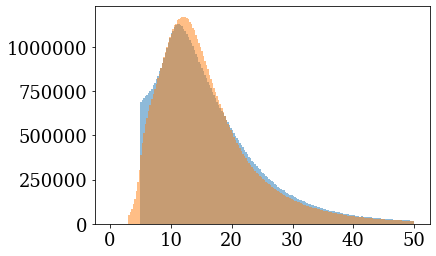

In [18]:
plt.hist(mc.query('pass_reco==1')['track_jetpt'],range=(0,50),bins=200,alpha=0.5)
plt.hist(mc.query('pass_reco==1')['gen_track_jetpt'],range=(0,50),bins=200,alpha=0.5)

plt.show()

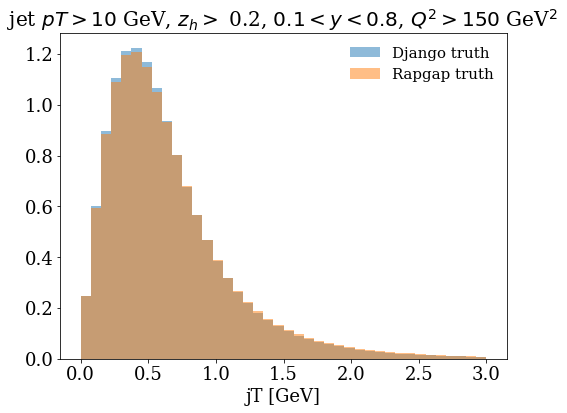

In [19]:
fig = plt.figure(figsize=(8,6))
#plt.hist(mc.query('pass_reco==1 and track_z>0.2 and track_jetpt>10')['track_jt'],bins=40,range=(0,3),**plot_style_2,label='MC reco')
plt.hist(mc.query('pass_reco==1 and track_z>0.2 and track_jetpt>10')['gen_track_jt'],bins=40,range=(0,3),**plot_style_2, label=mc_name+' truth')
plt.hist(altmc.query('pass_reco==1 and track_z>0.2 and track_jetpt>10')['gen_track_jt'],bins=40,range=(0,3),**plot_style_2, label=altmc_name +' truth')

#plt.hist(data.query('pass_reco==1 and track_z>0.2 and track_jetpt>10')['track_jt'],bins=40,range=(0,3),**plot_style_1, label='Data reco')
plt.legend(loc='best')
plt.xlabel('jT [GeV]')
plt.title('jet $pT > 10$ GeV, $z_{h} >$ 0.2, $0.1<y<0.8$, $Q^{2}>150$ GeV$^{2}$ ',fontsize=20)
plt.show()

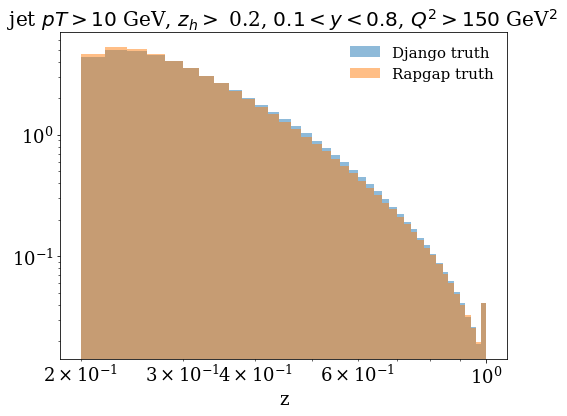

In [20]:
fig = plt.figure(figsize=(8,6))
#plt.hist(mc.query('pass_reco==1 and track_z>0.2 and track_jetpt>10')['track_jt'],bins=40,range=(0,3),**plot_style_2,label='MC reco')
plt.hist(mc.query('pass_reco==1 and track_z>0.2 and track_jetpt>10')['gen_track_z'],bins=40,range=(0.2,1),**plot_style_2, label=mc_name+' truth')
plt.hist(altmc.query('pass_reco==1 and track_z>0.2 and track_jetpt>10')['gen_track_z'],bins=40,range=(0.2,1),**plot_style_2, label=altmc_name +' truth')

#plt.hist(data.query('pass_reco==1 and track_z>0.2 and track_jetpt>10')['track_jt'],bins=40,range=(0,3),**plot_style_1, label='Data reco')
plt.legend(loc='best')
plt.xlabel('z')
plt.xscale('log')
plt.yscale('log')

plt.title('jet $pT > 10$ GeV, $z_{h} >$ 0.2, $0.1<y<0.8$, $Q^{2}>150$ GeV$^{2}$ ',fontsize=20)
plt.show()

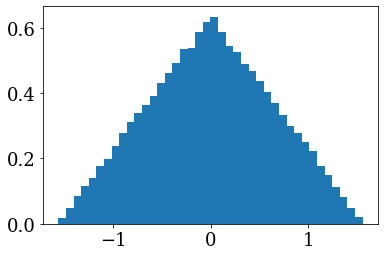

In [21]:
h = plt.hist(np.random.triangular(-np.pi/2.0, 0, np.pi/2.0, 100000), bins=40,
             density=True)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


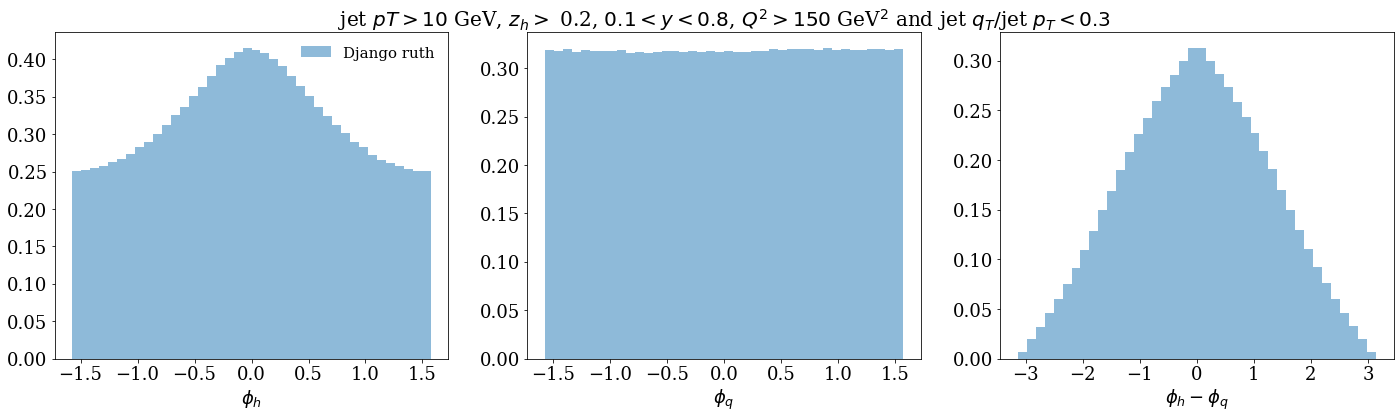

In [22]:
fig,ax = plt.subplots(1,3,figsize=(24,6))

cut = ' gen_track_z>0.2 and gen_track_jetpt>10 and gen_track_jetqtnorm < 0.3 and pass_reco==1'
ax[0].hist(mc.query(cut)['gen_track_phi'],bins=40,**plot_style_2, label= mc_name + ' ruth')
ax[1].hist(mc.query(cut)['gen_track_jetphiq'],bins=40,**plot_style_2, label= mc_name + ' ruth')
ax[2].hist(mc.query(cut)['gen_track_dphi'],bins=40,**plot_style_2, label= mc_name + ' ruth')

ax[0].legend(loc='best')
ax[0].set_xlabel('$\phi_{h}$')
ax[1].set_xlabel('$\phi_{q}$')
ax[2].set_xlabel('$\phi_{h} - \phi_{q}$')

ax[1].set_title('jet $pT > 10$ GeV, $z_{h} >$ 0.2, $0.1<y<0.8$, $Q^{2}>150$ GeV$^{2}$ and jet $q_{T}/$jet $p_{T}<0.3$',fontsize=20)

plt.show()

[0.01281736 0.03874345 0.06720266 0.10024573 0.13850314 0.17943324
 0.21704293 0.25060531 0.27939648 0.30586562 0.30631014 0.27980599
 0.25074726 0.21852031 0.18060898 0.13952245 0.10088683 0.06775971
 0.03914268 0.01284818]
[0.01601527 0.0480111  0.07959528 0.11159494 0.14317148 0.17517463
 0.20684446 0.23890715 0.27082466 0.30221687 0.30252409 0.27030445
 0.23876834 0.2069839  0.1748343  0.14345101 0.11101901 0.07969684
 0.04780862 0.01595032]


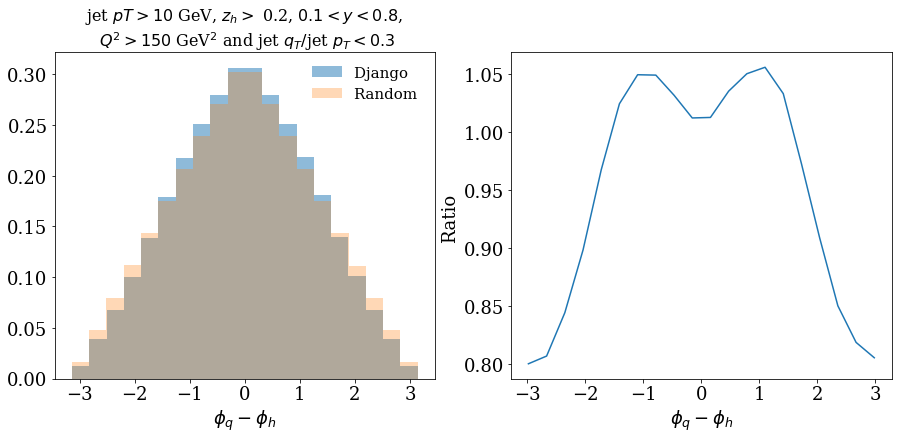

In [23]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

cut = ' gen_track_z>0.2 and gen_track_jetpt>10 and gen_track_jetqtnorm < 0.3'
#plt.hist(mc.query('pass_reco==1 and track_z>0.2 and track_jetpt>10')['track_phi'],bins=40,**plot_style_2,label='MC reco')
y,x, _ = ax[0].hist(mc.query(cut)['gen_track_dphi'],bins=20,**plot_style_2, label= mc_name + ' ')
#plt.hist(altmc.query(cut)['gen_track_phi'],bins=40,**plot_style_2, label=altmc_name + ' truth')
den,x, _ = ax[0].hist(np.random.triangular(-np.pi, 0, np.pi, 10000000), bins=20, alpha=0.3, label='Random ',
             density=True)
#plt.hist(data.query('pass_reco==1 and track_z>0.2 and track_jetpt>10')['track_phi'],bins=40,**plot_style_1, label='Data reco')

ax[0].legend(loc='best')
ax[0].set_xlabel('$\phi_{q} - \phi_{h}$')
ax[0].set_title('jet $pT > 10$ GeV, $z_{h} >$ 0.2, $0.1<y<0.8$, \n $Q^{2}>150$ GeV$^{2}$ and jet $q_{T}/$jet $p_{T}<0.3$',fontsize=16)


print(y)
print(den)
ratio = np.true_divide(y,den)
x= (x[1:] + x[:-1])/2.0
ax[1].plot(x,ratio)
ax[1].set_ylabel('Ratio ')
ax[1].set_xlabel('$\phi_{q} - \phi_{h}$')

plt.show()


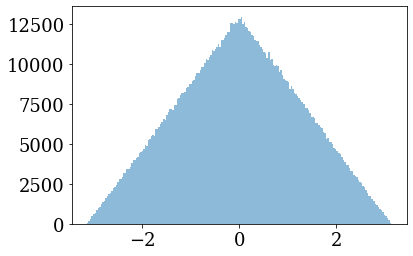

In [24]:
plt.hist(data.query('pass_reco==1')['track_dphi'],bins=200,alpha=0.5)
plt.show()

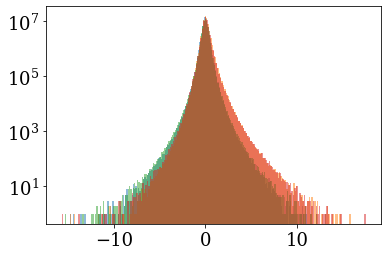

In [25]:
plt.hist(mc.query('pass_reco==1')['track_jy'],bins=200,alpha=0.5)
plt.hist(mc.query('pass_reco==1')['track_jx'],bins=200,alpha=0.5)
plt.hist(altmc.query('pass_reco==1')['track_jy'],bins=200,alpha=0.5)
plt.hist(altmc.query('pass_reco==1')['track_jx'],bins=200,alpha=0.5)
plt.yscale('log')
plt.show()

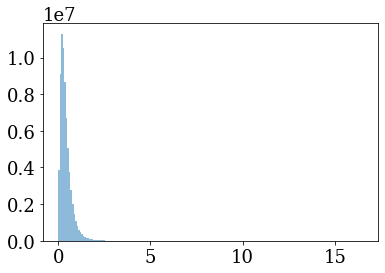

In [26]:
plt.hist(mc.query('pass_reco==1')['track_jt'],bins=200,alpha=0.5)

plt.show()

In [27]:
mc_cut = mc[:30000000]
altmc_cut = altmc[:3000000]

In [28]:
print(len(data))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts
print(len(altmc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts


1290978
20442880
30000000
2058245


### Define UniFold Algorithm


In [29]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

Using TensorFlow backend.


## Define features using just MC and alt MC *this is CLOSURE TEST*

In [44]:
norm_mc = mc_cut
norm_altmc =  altmc_cut

In [45]:
norm_mc.keys()

Index(['track_z', 'track_jt', 'track_phi', 'track_px', 'track_py', 'track_pz',
       'track_charge', 'track_jetpx', 'track_jetpy', 'track_jetpz',
       'gen_track_z', 'gen_track_jt', 'gen_track_phi', 'gen_track_px',
       'gen_track_py', 'gen_track_pz', 'gen_track_charge', 'gen_track_jetpx',
       'gen_track_jetpy', 'gen_track_jetpz', 'Q2', 'gen_Q2', 'y', 'gen_y',
       'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'pass_reco',
       'pass_truth', 'e_pt', 'logQ2', 'track_jetp', 'track_jeteta',
       'track_jetpt', 'track_jetqt', 'track_jetqtnorm', 'track_jetqty',
       'track_jetqtx', 'track_jetphiq', 'track_p', 'track_pt', 'track_jy',
       'track_jx', 'track_phih', 'track_dphi', 'gen_logQ2', 'gen_track_jetp',
       'gen_track_jeteta', 'gen_track_jetpt', 'gen_track_jetqt',
       'gen_track_jetqtnorm', 'gene_pt', 'gen_track_jy', 'gen_track_jx',
       'gen_track_phih', 'gen_track_jetqty', 'gen_track_jetqtx',
       'gen_track_jetphiq', 'gen_track_p', 'gen_track_pt

In [46]:
#norm_mc=(mc_cut-mc_cut.query('pass_reco==1').mean())/mc_cut.query('pass_reco==1').std()
#norm_mc['pass_reco'] = mc_cut['pass_reco']

#norm_altmc=(altmc_cut-altmc_cut.query('pass_reco==1').mean())/altmc_cut.query('pass_reco==1').std()
#norm_altmc['pass_reco'] = altmc_cut['pass_reco']

In [57]:
theta0_G=np.c_[(norm_mc['gene_px'],       norm_mc['gene_py'],                 norm_mc['gene_pz'],
                norm_mc['gen_track_px'],  norm_mc['gen_track_py'],       norm_mc['gen_track_pz'],
                norm_mc['gen_track_jetpx'], norm_mc['gen_track_jetpy'], norm_mc['gen_track_jetpz'],
                norm_mc['gen_track_jt'], norm_mc['gen_track_jx'], norm_mc['gen_track_jy'],
                #norm_mc['gen_track_jetqt'], norm_mc['gen_track_jetqtx'], norm_mc['gen_track_jetqty'],
                norm_mc['gen_track_z']
               )]

theta0_S=np.c_[(norm_mc['e_px'],       norm_mc['e_py'],         norm_mc['e_pz'],
                norm_mc['track_px'],   norm_mc['track_py'],     norm_mc['track_pz'],
                norm_mc['track_jetpx'], norm_mc['track_jetpy'], norm_mc['track_jetpz'],
                norm_mc['track_jt'],  norm_mc['track_jx'], norm_mc['track_jy'],
                #norm_mc['track_jetqt'], norm_mc['track_jetqtx'], norm_mc['track_jetqty'],
                norm_mc['track_z']


                
               )]


theta_unknown_G=np.c_[(norm_altmc['gene_px'],         norm_altmc['gene_py'], norm_altmc['gene_pz'],
                       norm_altmc['gen_track_px'],    norm_altmc['gen_track_py'],norm_altmc['gen_track_pz'],
                       norm_altmc['gen_track_jetpx'], norm_altmc['gen_track_jetpy'],norm_altmc['gen_track_jetpz'],
                       norm_altmc['gen_track_jt'],  norm_altmc['gen_track_jx'], norm_altmc['gen_track_jy'],
                       #norm_altmc['gen_track_jetqt'], norm_altmc['gen_track_jetqtx'], norm_altmc['gen_track_jetqty'],
                       norm_altmc['gen_track_z']

                      )]
         
theta_unknown_S=np.c_[(norm_altmc['e_px'],        norm_altmc['e_py'],        norm_altmc['e_pz'],
                       norm_altmc['track_px'],    norm_altmc['track_py'],    norm_altmc['track_pz'],
                       norm_altmc['track_jetpx'], norm_altmc['track_jetpy'], norm_altmc['track_jetpz'],
                       norm_altmc['track_jt'],  norm_altmc['track_jx'], norm_altmc['track_jy'],
                       #norm_altmc['track_jetqt'], norm_altmc['track_jetqtx'], norm_altmc['track_jetqty'],
                       norm_altmc['track_z']


                      )]



In [58]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

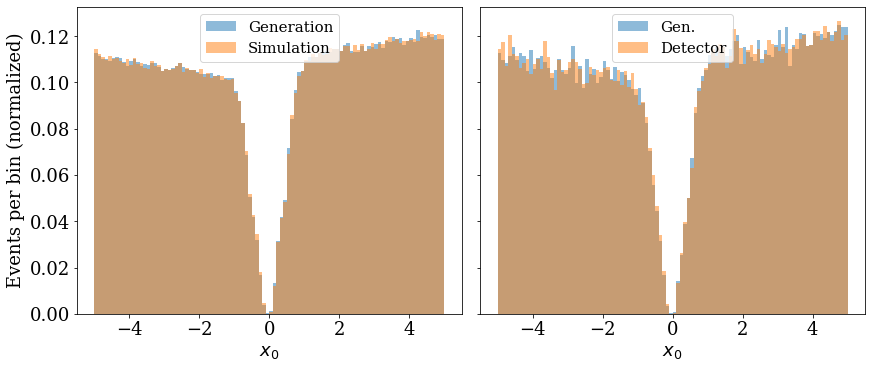

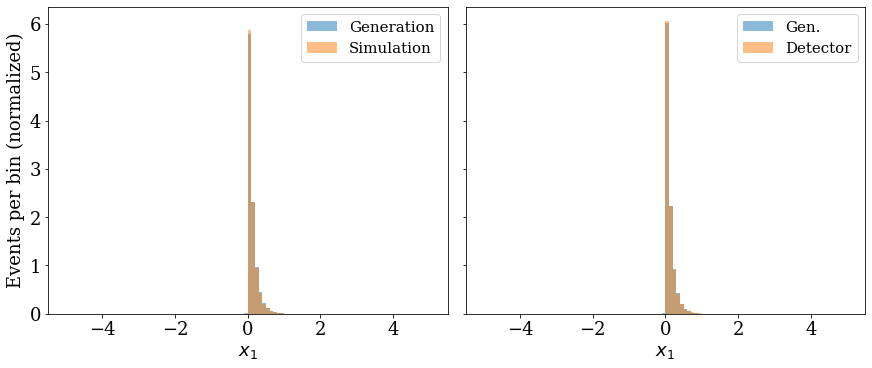

In [49]:
bins = np.linspace(-5,5, 101)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)


ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

bins = np.linspace(-5,5, 101)
#bins = np.linspace(0,2, 101)
#bins = np.linspace(0,1,100)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)

ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)






plt.setp(legend.get_title(), multialignment='center')

fig.show()

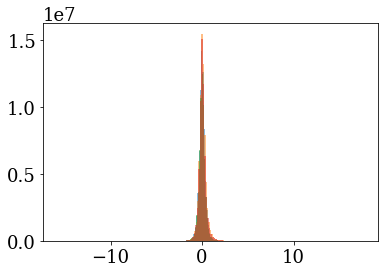

In [50]:
plt.hist(mc.query('pass_reco==1')['track_jy'],bins=200,alpha=0.5)
plt.hist(mc.query('pass_reco==1')['track_jx'],bins=200,alpha=0.5)
plt.hist(altmc.query('pass_reco==1')['track_jy'],bins=200,alpha=0.5)
plt.hist(altmc.query('pass_reco==1')['track_jx'],bins=200,alpha=0.5)
plt.show()

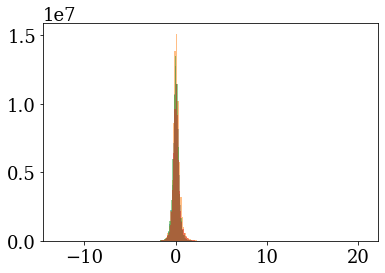

In [51]:
plt.hist(mc.query('pass_reco==1')['gen_track_jy'],bins=200,alpha=0.5)
plt.hist(mc.query('pass_reco==1')['gen_track_jx'],bins=200,alpha=0.5)
plt.hist(altmc.query('pass_reco==1')['gen_track_jy'],bins=200,alpha=0.5)
plt.hist(altmc.query('pass_reco==1')['gen_track_jx'],bins=200,alpha=0.5)
plt.show()

## Define Multifold 

In [59]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    

    weights = np.empty(shape=(iterations, 2, len(theta0_G))) #this was 0
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))

    inputs = Input((num_observables, ))
     #inputs = Input((2, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data (not MC weights)

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        #theta0_G[theta0_S[:,0]!=-10][:,1]
        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_1[X_train_1[:,0]!=-10],
              Y_train_1[X_train_1[:,0]!=-10],
              sample_weight=w_train_1[X_train_1[:,0]!=-10],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1[:,0]!=-10], Y_test_1[X_test_1[:,0]!=-10], w_test_1[X_test_1[:,0]!=-10]),
              callbacks=[earlystopping],
              verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1. #these are events that don't pass reco; take the prior.
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_push
    return weights, model

## Unfold two variables simultaneously

In [60]:
K.clear_session()

In [61]:
iterations = 3# use ~4 iterations
num_observables= 13

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S)


ITERATION: 1

STEP 1

Train on 17582536 samples, validate on 5860335 samples
Epoch 1/200
17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9427 - acc: 0.8719 - val_loss: 0.9401 - val_acc: 0.8720
Epoch 2/200
17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9401 - acc: 0.8720 - val_loss: 0.9395 - val_acc: 0.8720
Epoch 3/200
17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9399 - acc: 0.8720 - val_loss: 0.9394 - val_acc: 0.8720
Epoch 4/200
17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9398 - acc: 0.8720 - val_loss: 0.9393 - val_acc: 0.8720
Epoch 5/200
17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9398 - acc: 0.8720 - val_loss: 0.9394 - val_acc: 0.8720
Epoch 6/200
17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9397 - acc: 0.8720 - val_loss: 0.9392 - val_acc: 0.8720
Epoch 7/200
17582536/17582536 [===========================

17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9389 - acc: 0.8720 - val_loss: 0.9386 - val_acc: 0.8720
Epoch 58/200
17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9388 - acc: 0.8720 - val_loss: 0.9386 - val_acc: 0.8720
Epoch 59/200
17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9388 - acc: 0.8720 - val_loss: 0.9388 - val_acc: 0.8720
Epoch 60/200
17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9388 - acc: 0.8720 - val_loss: 0.9386 - val_acc: 0.8720
Epoch 61/200
17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9388 - acc: 0.8720 - val_loss: 0.9386 - val_acc: 0.8720
Epoch 62/200
17582536/17582536 [==============================] - 19s 1us/step - loss: 0.9388 - acc: 0.8720 - val_loss: 0.9386 - val_acc: 0.8720
Epoch 63/200
17582536/17582536 [==============================] - 20s 1us/step - loss: 0.9388 - acc: 0.8720 - val_loss: 0.9386 - val_acc: 0.872

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45000000/45000000 [==============================] - 52s 1us/step - loss: 0.3724 - acc: 0.5000 - val_loss: 0.3723 - val_acc: 0.4998
Epoch 34/200
45000000/45000000 [==============================] - 51s 1us/step - loss: 0.3724 - acc: 0.5000 - val_loss: 0.3724 - val_acc: 0.4998
Epoch 35/200
45000000/45000000 [==============================] - 51s 1us/step - loss: 0.3724 - acc: 0.5000 - val_loss: 0.3724 - val_acc: 0.4998
Epoch 36/200
45000000/45000000 [==============================] - 52s 1us/step - loss: 0.3724 - acc: 0.5000 - val_loss: 0.3724 - val_acc: 0.4998
Epoch 37/200
45000000/45000000 [==============================] - 52s 1us/step - loss: 0.3724 - acc: 0.5001 - val_loss: 0.3723 - val_acc: 0.4998
Epoch 38/200
45000000/45000000 [==============================] - 52s 1us/step - loss: 0.3724 - acc: 0.5000 - val_loss: 0.3723 - val_acc: 0.4998
Epoch 39/200
45000000/45000000 [==============================] - 52s 1us/step - loss: 0.3724 - acc: 0.5001 - val_loss: 0.3723 - val_acc: 0.499

17581339/17581339 [==============================] - 20s 1us/step - loss: 0.8183 - acc: 0.8710 - val_loss: 0.8178 - val_acc: 0.8713
Epoch 41/200
17581339/17581339 [==============================] - 20s 1us/step - loss: 0.8183 - acc: 0.8710 - val_loss: 0.8178 - val_acc: 0.8710
Epoch 42/200
17581339/17581339 [==============================] - 20s 1us/step - loss: 0.8183 - acc: 0.8710 - val_loss: 0.8178 - val_acc: 0.8714
Epoch 43/200
17581339/17581339 [==============================] - 20s 1us/step - loss: 0.8183 - acc: 0.8709 - val_loss: 0.8178 - val_acc: 0.8712
Epoch 44/200
17581339/17581339 [==============================] - 20s 1us/step - loss: 0.8183 - acc: 0.8710 - val_loss: 0.8178 - val_acc: 0.8711
Epoch 45/200
17581339/17581339 [==============================] - 20s 1us/step - loss: 0.8183 - acc: 0.8709 - val_loss: 0.8179 - val_acc: 0.8711
Epoch 46/200
17581339/17581339 [==============================] - 20s 1us/step - loss: 0.8183 - acc: 0.8710 - val_loss: 0.8178 - val_acc: 0.871

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45000000/45000000 [==============================] - 52s 1us/step - loss: 0.3722 - acc: 0.5000 - val_loss: 0.3723 - val_acc: 0.4999
Epoch 4/200
45000000/45000000 [==============================] - 52s 1us/step - loss: 0.3721 - acc: 0.5000 - val_loss: 0.3722 - val_acc: 0.4999
Epoch 5/200
45000000/45000000 [==============================] - 52s 1us/step - loss: 0.3721 - acc: 0.5000 - val_loss: 0.3722 - val_acc: 0.4999
Epoch 6/200
45000000/45000000 [==============================] - 51s 1us/step - loss: 0.3721 - acc: 0.5000 - val_loss: 0.3722 - val_acc: 0.4999
Epoch 7/200
45000000/45000000 [==============================] - 52s 1us/step - loss: 0.3720 - acc: 0.5000 - val_loss: 0.3723 - val_acc: 0.4999
Epoch 8/200
45000000/45000000 [==============================] - 52s 1us/step - loss: 0.3720 - acc: 0.5000 - val_loss: 0.3723 - val_acc: 0.4999
Epoch 9/200
45000000/45000000 [==============================] - 51s 1us/step - loss: 0.3720 - acc: 0.5000 - val_loss: 0.3722 - val_acc: 0.4999
Epoc

17582804/17582804 [==============================] - 20s 1us/step - loss: 0.8169 - acc: 0.8713 - val_loss: 0.8191 - val_acc: 0.8713
Epoch 28/200
17582804/17582804 [==============================] - 20s 1us/step - loss: 0.8169 - acc: 0.8713 - val_loss: 0.8191 - val_acc: 0.8714
Epoch 29/200
17582804/17582804 [==============================] - 20s 1us/step - loss: 0.8169 - acc: 0.8713 - val_loss: 0.8191 - val_acc: 0.8716
Epoch 30/200
17582804/17582804 [==============================] - 20s 1us/step - loss: 0.8169 - acc: 0.8714 - val_loss: 0.8191 - val_acc: 0.8715
Epoch 31/200
17582804/17582804 [==============================] - 20s 1us/step - loss: 0.8169 - acc: 0.8713 - val_loss: 0.8191 - val_acc: 0.8696
Epoch 32/200
17582804/17582804 [==============================] - 20s 1us/step - loss: 0.8169 - acc: 0.8713 - val_loss: 0.8191 - val_acc: 0.8711
Epoch 33/200
17582804/17582804 [==============================] - 20s 1us/step - loss: 0.8169 - acc: 0.8713 - val_loss: 0.8190 - val_acc: 0.871

## Put weights into MC dataframe

In [62]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Check that weights are reasonable

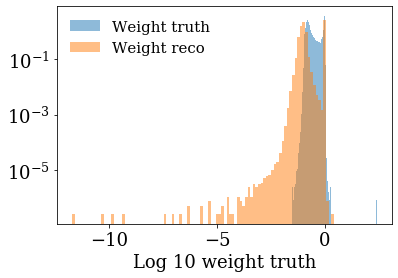

2.490985631942749
0.06142384558916092
2.4804909229278564
0.0020105810835957527
 
1.470751166343689
0.004628205671906471
1.8133231401443481
1.9675543746350277e-12
 
248.80221557617188
0.029086897149682045
2.6293420791625977
1.951216315257409e-12
 


In [63]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

In [64]:
print(len(mc_cut))
mc_cut.query('weight_truth>10000')
print(len(mc_cut.query(' weight_reco>0.01')))

mc_cut = mc_cut.query('weight_reco<100 and weight_reco>0.01')
#altmc_cut = altmc_cut.query('weight_truth<10000')
print(len(mc_cut))

mc_cut = mc_cut.query('weight_truth<100 and weight_truth>0.01')
print(len(mc_cut))


30000000
29999505
29999505
29999504


## Closure Test

The query is: pass_reco==1 and gen_y>0.2 and gen_y<0.7 and gen_Q2>150 and gen_track_pt>0.2 and gen_track_jetpt>10
ITERATION: 3


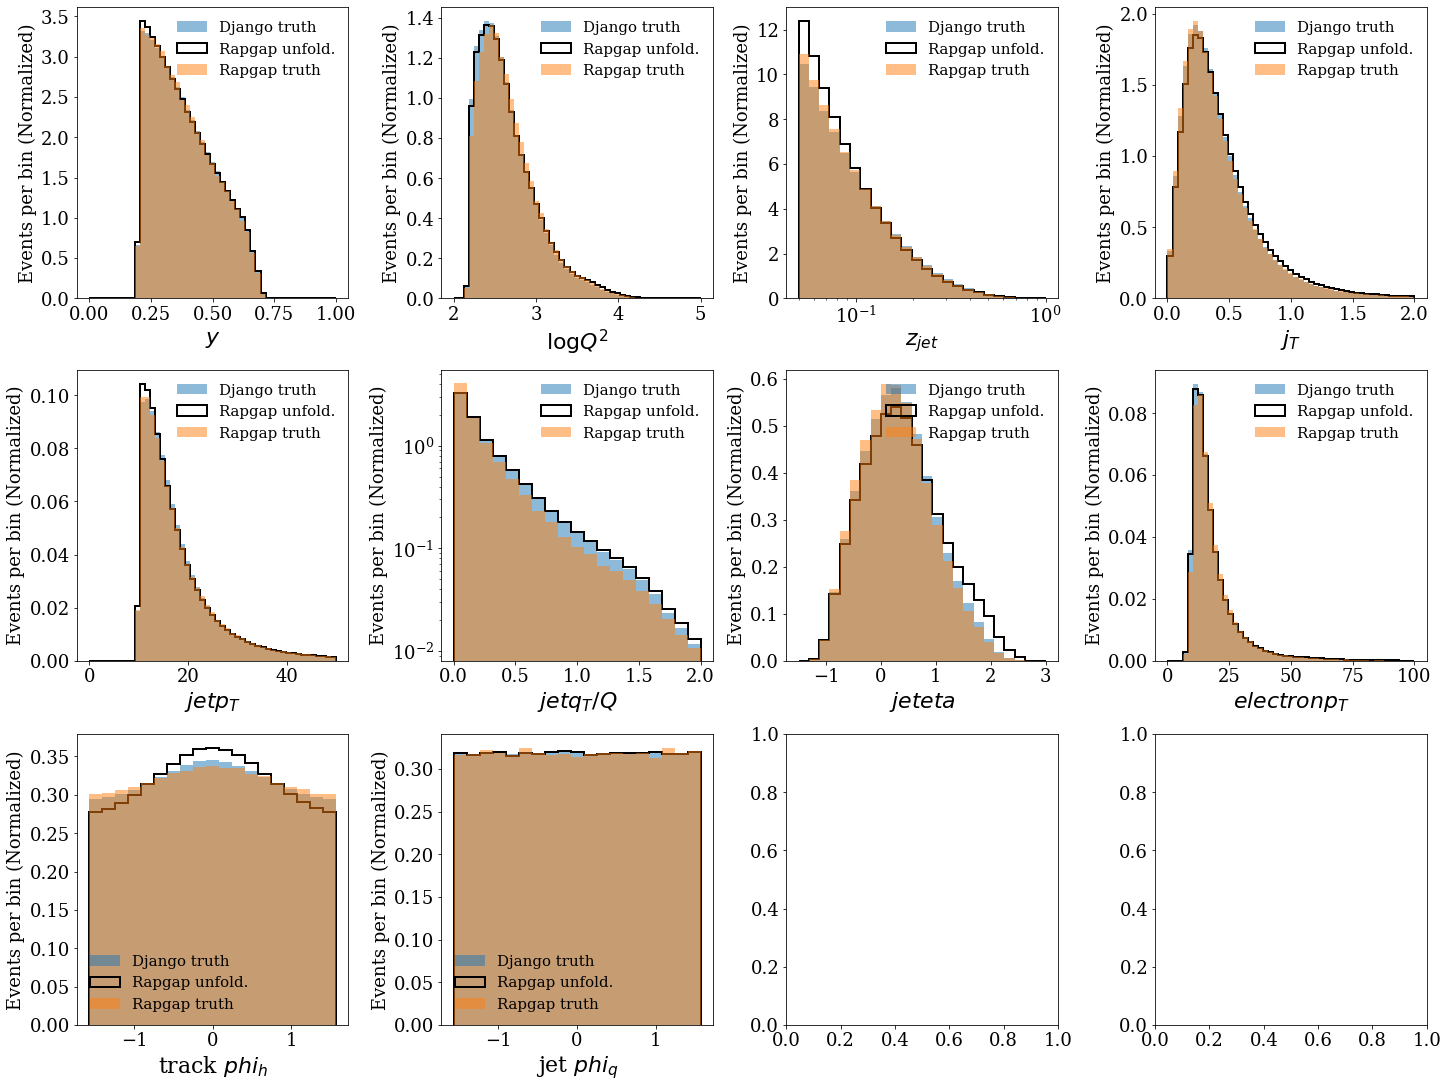

In [65]:
event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
track_selection = 'gen_track_pt>0.2'
jet_selection    = 'gen_track_jetpt>10'
query = 'pass_reco==1 and ' + event_selection + ' and ' + track_selection + ' and ' + jet_selection
print('The query is:' , query)

label1 = r'Django truth'
label2 = r'Rapgap unfold.'
label3 = r'Rapgap truth'


for i in range(len(weights)):
    if i<2: continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(3,
                           4,
                           figsize=(20, 15),
                           constrained_layout=True)
    
    ax = ax.flatten()
    bins = np.linspace(0.0, 1.0,50 )

    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0].hist(altmc_cut.query(query)['gen_y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0].legend(frameon=False)

    bins = np.linspace(2, 5,50 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1].hist(altmc_cut.query(query)['gen_logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[1].legend(frameon=False)

    
    bins = np.logspace(np.log10(0.05),0,25 )

    ax[2].set_xlabel(r'$z_{jet} $',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['gen_track_z'], bins=bins, label=label1, **plot_style_2)
    ax[2].hist(mc_cut.query(query)['gen_track_z'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[2].hist(altmc_cut.query(query)['gen_track_z'],
               bins=bins,
               label=label3,
               **plot_style_2)
    #ax[0,2].set_yscale('log')
    ax[2].set_xscale('log')

    ax[2].legend(frameon=False)

    bins = np.linspace(0,2,50 )

    ax[3].set_xlabel(r'$j_{T} $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['gen_track_jt'], bins=bins, label=label1, **plot_style_2)
    ax[3].hist(mc_cut.query(query)['gen_track_jt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[3].hist(altmc_cut.query(query)['gen_track_jt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    #ax[1,0].set_yscale('log')
    ax[3].legend(frameon=False)

    bins = np.linspace(0,50,50 )

    ax[4].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['gen_track_jetpt'], bins=bins, label=label1, **plot_style_2)
    ax[4].hist(mc_cut.query(query)['gen_track_jetpt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[4].hist(altmc_cut.query(query)['gen_track_jetpt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[4].legend(frameon=False)

    bins = np.linspace(0,2,20 )

    
    ax[5].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['gen_track_jetqtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[5].hist(mc_cut.query(query)['gen_track_jetqtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[5].hist(altmc_cut.query(query)['gen_track_jetqtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    
    ax[5].set_yscale('log')
    ax[5].legend(frameon=False)

    bins = np.linspace(-1.5,3,25 )

    ax[6].set_xlabel(r'$jet eta $',fontsize=22)
    ax[6].set_ylabel('Events per bin (Normalized)')
    ax[6].hist(mc_cut.query(query)['gen_track_jeteta'], bins=bins, label=label1, **plot_style_2)
    ax[6].hist(mc_cut.query(query)['gen_track_jeteta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[6].hist(altmc_cut.query(query)['gen_track_jeteta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[6].legend(frameon=False,loc='best')

    bins = np.linspace(0,100,50)

    ax[7].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[7].set_ylabel('Events per bin (Normalized)')
    ax[7].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[7].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[7].hist(altmc_cut.query(query)['gene_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[7].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(-np.pi/2.0,np.pi/2.0,20)

    ax[8].set_xlabel('track $phi_{h}$',fontsize=22)
    ax[8].set_ylabel('Events per bin (Normalized)')
    ax[8].hist(mc_cut.query(query)['gen_track_phih'], bins=bins, label=label1, **plot_style_2)
    ax[8].hist(mc_cut.query(query)['gen_track_phih'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[8].hist(altmc_cut.query(query)['gen_track_phih'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[8].legend(frameon=False,loc='lower left')
    
    bins = np.linspace(-np.pi/2.0,np.pi/2.0,20)

    ax[9].set_xlabel('jet $phi_{q}$',fontsize=22)
    ax[9].set_ylabel('Events per bin (Normalized)')
    ax[9].hist(mc_cut.query(query)['gen_track_jetphiq'], bins=bins, label=label1, **plot_style_2)
    ax[9].hist(mc_cut.query(query)['gen_track_jetphiq'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[9].hist(altmc_cut.query(query)['gen_track_jetphiq'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[9].legend(frameon=False,loc='lower left')

    fig.savefig('figures/Closure_HadronInJet_%i_iter.png'%i)    

## Plot CLOSURE TEST RESULTS, part II

The query is: pass_reco==1 and gen_y>0.2 and gen_y<0.7 and gen_Q2>150 and gen_track_pt>0.2 and gen_track_jetpt>10
ITERATION: 3


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


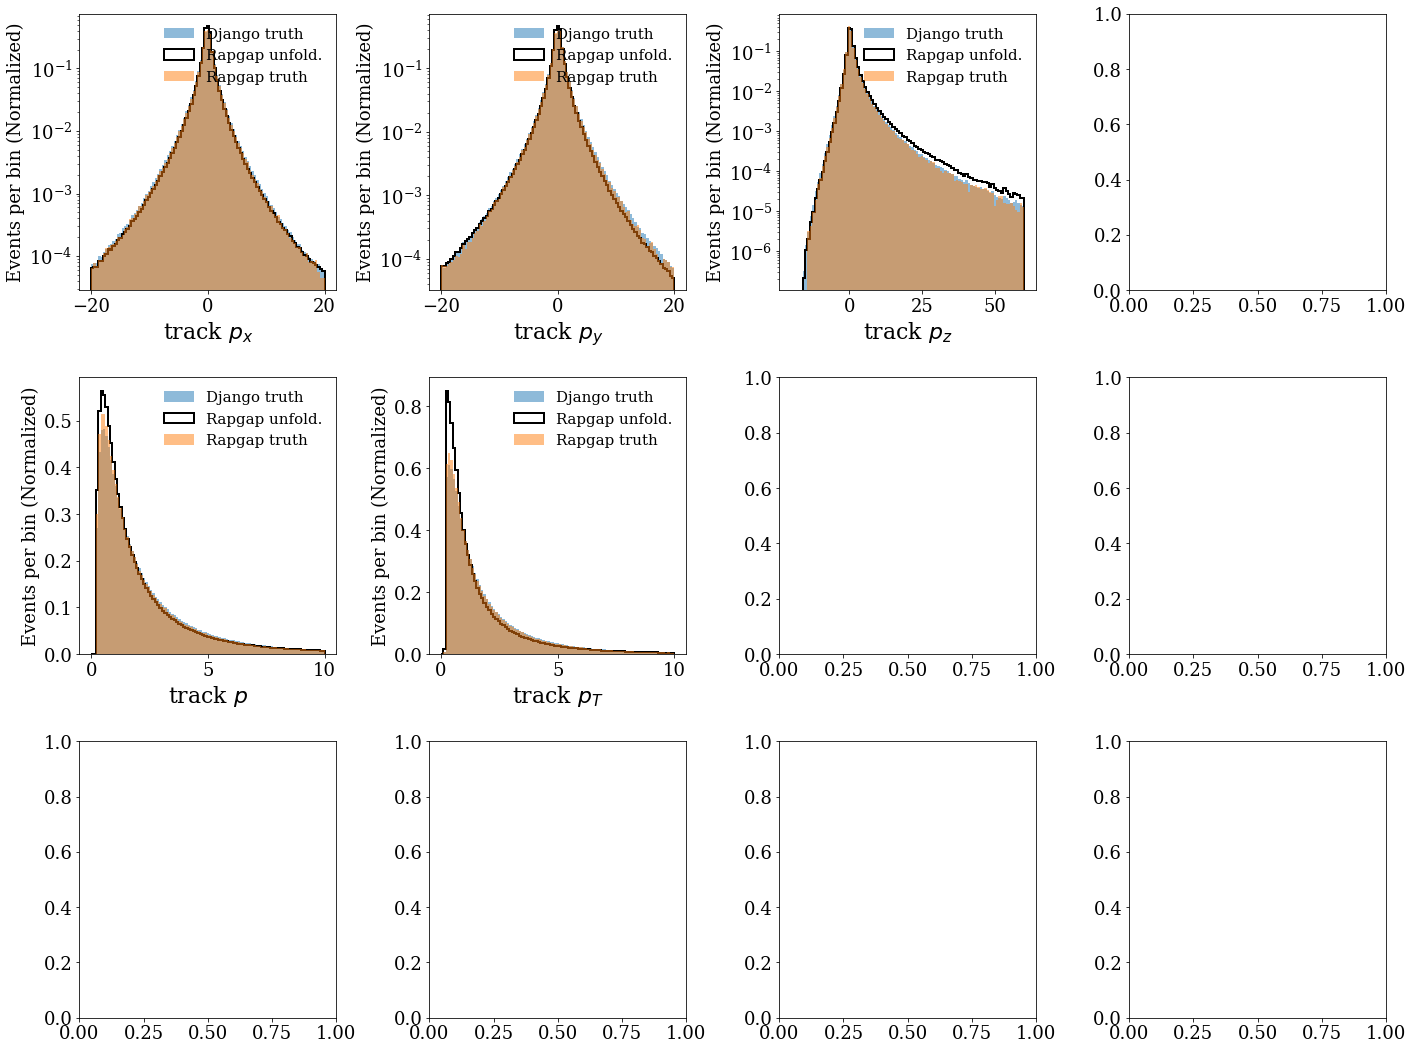

In [66]:
print('The query is:' , query)


for i in range(len(weights)):
    if i<2: continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(3,
                           4,
                           figsize=(20, 15),
                           constrained_layout=True)
    bins = np.linspace(-20.0, 20.0,100 )

    ax[0,0].set_xlabel('track $p_x$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['gen_track_px'], bins=bins, label=label1, **plot_style_2)
    ax[0,0].hist(mc_cut.query(query)['gen_track_px'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(altmc_cut.query(query)['gen_track_px'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,0].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(-20.0, 20.0,100 )

    ax[0,1].set_xlabel('track $p_y$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['gen_track_py'], bins=bins, label=label1, **plot_style_2)
    ax[0,1].hist(mc_cut.query(query)['gen_track_py'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(altmc_cut.query(query)['gen_track_py'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,1].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(-20.0, 60.0,100 )

    ax[0,2].set_xlabel('track $p_z$',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['gen_track_pz'], bins=bins, label=label1, **plot_style_2)
    ax[0,2].hist(mc_cut.query(query)['gen_track_pz'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(altmc_cut.query(query)['gen_track_pz'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,2].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(0, 10,100 )

    ax[1,0].set_xlabel('track $p$',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['gen_track_p'], bins=bins, label=label1, **plot_style_2)
    ax[1,0].hist(mc_cut.query(query)['gen_track_p'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(altmc_cut.query(query)['gen_track_p'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[1,0].legend(frameon=False,loc='best')
    
    bins = np.linspace(0.0, 10.0,100 )

    

    ax[1,1].set_xlabel('track $p_{T}$',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['gen_track_pt'],bins=bins, label=label1, **plot_style_2)
    ax[1,1].hist(mc_cut.query(query)['gen_track_pt'],
               bins=bins,
               weights = mc_cut.query(query)['weight_truth'] ,
               label=label2,
               **plot_style_1)

    ax[1,1].hist(altmc_cut.query(query)['gen_track_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[1,1].legend(frameon=False,loc='best')
    
    
   
    
    
    
    ax[0,0].set_yscale('log')
    ax[0,1].set_yscale('log')
    ax[0,2].set_yscale('log')

    plt.tight_layout()
    fig.savefig('figures/Closure_2_HadronInJet_%i_iter.png'%i)  

## Show the reweighting of the reco

The query is: pass_reco==1 
ITERATION: 3


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:205: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


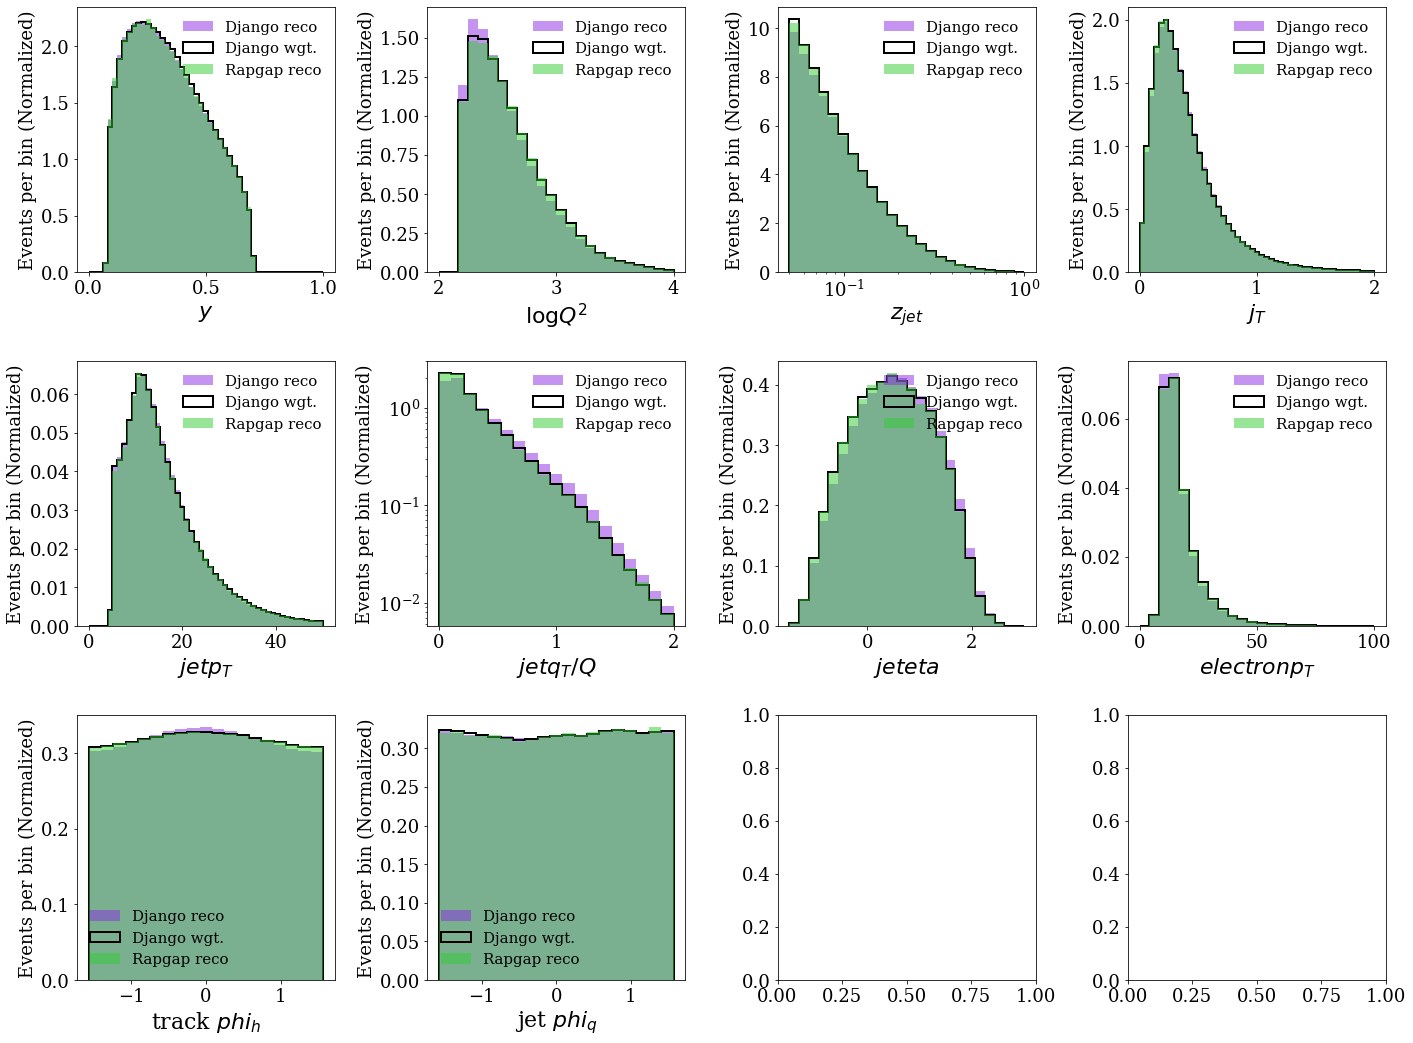

In [67]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = r'Django reco'
label2 = r'Django wgt.'
label3 = r'Rapgap reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):
    if i<2: continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(3,
                           4,
                           figsize=(20, 15),
                           constrained_layout=True)
    ax = ax.flatten()
    bins = np.linspace(0.0, 1.0,50 )

    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0].hist(altmc_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1].hist(altmc_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1].legend(frameon=False,loc='best')

    
    bins = np.logspace(np.log10(0.05),0,25 )

    ax[2].set_xlabel(r'$z_{jet} $',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['track_z'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[2].hist(mc_cut.query(query)['track_z'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[2].hist(altmc_cut.query(query)['track_z'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    ax[2].set_xscale('log')
    ax[2].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,2.0,50 )

    ax[3].set_xlabel(r'$j_{T} $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['track_jt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[3].hist(mc_cut.query(query)['track_jt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[3].hist(altmc_cut.query(query)['track_jt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[3].legend(frameon=False,loc='best')
    
    bins = np.linspace(0,50,50 )

    ax[4].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['track_jetpt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[4].hist(mc_cut.query(query)['track_jetpt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[4].hist(altmc_cut.query(query)['track_jetpt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    ax[4].legend(frameon=False,loc='best')

    bins = np.linspace(0,2,20 )

    
    ax[5].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['track_jetqtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[5].hist(mc_cut.query(query)['track_jetqtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[5].hist(altmc_cut.query(query)['track_jetqtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[5].legend(frameon=False,loc='best')
    ax[5].set_yscale('log')

    bins = np.linspace(-1.5,3,25 )

    ax[6].set_xlabel(r'$jet eta $',fontsize=22)
    ax[6].set_ylabel('Events per bin (Normalized)')
    ax[6].hist(mc_cut.query(query)['track_jeteta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[6].hist(mc_cut.query(query)['track_jeteta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[6].hist(altmc_cut.query(query)['track_jeteta'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[6].legend(frameon=False,loc='best')

    bins = np.linspace(0,100,25)

    ax[7].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[7].set_ylabel('Events per bin (Normalized)')
    ax[7].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[7].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[7].hist(altmc_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[7].legend(frameon=False,loc='best')
    
    
    
    
    bins = np.linspace(-np.pi/2.0,np.pi/2.0,20)

    ax[8].set_xlabel('track $phi_{h}$',fontsize=22)
    ax[8].set_ylabel('Events per bin (Normalized)')
    ax[8].hist(mc_cut.query(query)['track_phih'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[8].hist(mc_cut.query(query)['track_phih'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[8].hist(altmc_cut.query(query)['track_phih'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[8].legend(frameon=False,loc='lower left')
    
    bins = np.linspace(-np.pi/2.0,np.pi/2.0,20)

    ax[9].set_xlabel('jet $phi_{q}$',fontsize=22)
    ax[9].set_ylabel('Events per bin (Normalized)')
    ax[9].hist(mc_cut.query(query)['track_jetphiq'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[9].hist(mc_cut.query(query)['track_jetphiq'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[9].hist(altmc_cut.query(query)['track_jetphiq'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[9].legend(frameon=False,loc='lower left')
    
    
    
    plt.tight_layout()
    fig.savefig('figures/Closure_3_HadronInJet_%i_iter.png'%i)  
    
    

## Closure for differential plots

 gen_Q2 > 150.00 and gen_Q2 <500.00 and gen_y>0.2 and gen_y<0.7 and gen_track_jetpt>20 and gen_track_z>0.2
###########
 gen_Q2 > 500.00 and gen_Q2 <1000.00 and gen_y>0.2 and gen_y<0.7 and gen_track_jetpt>20 and gen_track_z>0.2
###########
 gen_Q2 > 1000.00 and gen_Q2 <10000.00 and gen_y>0.2 and gen_y<0.7 and gen_track_jetpt>20 and gen_track_z>0.2
###########


Text(0, 0.5, 'Normalized entries')

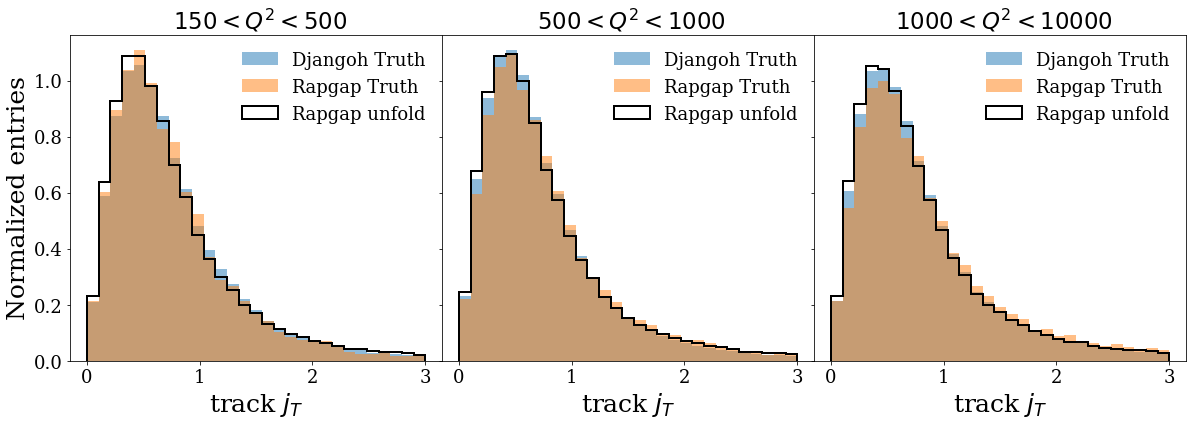

In [69]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.linspace(0,3,30)

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f and gen_y>0.2 and gen_y<0.7'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>20 and gen_track_z>0.2'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('track $j_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('track $j_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
   # axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['track_jt'],weights=mc_cut.query(cut+'and pass_reco==1')['weight_reco'],bins=bins,alpha=0.9,density=True, 
   #                  label='MC wgt to data reco',color='blue',lw=3,histtype='step')

    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['gen_track_jt'],bins=bins,weights=mc_cut.query(cut+'and pass_reco==1')['weight_truth'],label = 'Unfolded',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,label='Djangoh Truth',**plot_style_2)
    axs[counter].hist(altmc_cut.query(cut)['gen_track_jt'],bins=bins,label='Rapgap Truth',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.linspace(-np.pi,np.pi,40)

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(24,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(0.2,0.3), (0.3,0.5),(0.5,1.0)]):
    cut = ' gen_Q2 > 150  and gen_y>0.2 and gen_y<0.7 and gen_track_z>%2.2f and gen_track_z<%2.2f'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>10 and gen_track_z>0.2'
    print (cut)

    print ('###########')
    axs[counter].xaxis.set_label_text('track $j_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('track $j_{T}$', fontsize=25)
    axs[counter].hist(mc_cut.query(cut)['gen_track_phi'],bins=bins,label='Djangoh Truth',**plot_style_2)
    axs[counter].hist(altmc_cut.query(cut)['gen_track_phi'],bins=bins,label='Rapgap Truth',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_phi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)

    axs[counter].legend(prop={'size': 16}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< z < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)

## check weights

In [ ]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Compute some efficiency

In [ ]:
bins = np.logspace(-2,1.5,100)
num,x,_  = plt.hist(mc_cut.query('pass_reco==1')['gen_track_p'], weights=mc_cut.query('pass_reco==1')['weight_truth'],bins=bins,label='numerator, weighted',alpha=0.3)
den,x,_  = plt.hist(mc_cut['gen_track_p'], weights=mc_cut['weight_truth'],bins=bins,label='denominator, weighted',alpha=0.3)
x= (x[1:] + x[:-1])/2.0

plt.legend()
plt.show()
eff_weighted= np.true_divide(num,den)

In [ ]:
plt.plot(x,eff_weighted)

In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),20)
bins = np.linspace(0,3,20)

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>15 and gen_track_jetqtnorm<0.3 and gen_track_z>0.2'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('jet $p_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('jet $p_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['track_jt'],weights=mc_cut.query(cut+'and pass_reco==1')['weight_reco'],bins=bins,alpha=0.9,density=True, 
    #                  label='MC wgt to data reco',color='black',lw=3,histtype='step')

    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['gen_track_jt'],bins=bins,weights=mc_cut.query(cut+'and pass_reco==1')['weight_truth'],label = 'Unfolded',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfold + eff',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,label='MC true',histtype='step',density=True, color='green',lw=2)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


In [ ]:
K.clear_session()

## Define features with data

In [ ]:
mc_cut = mc[:1000000]
altmc_cut = altmc[:1000000]
data_cut = data[:300000]
print(len(mc_cut))
print(len(data_cut))

In [ ]:
mc_cut = pd.concat([mc_cut, altmc_cut])

In [ ]:
print(len(mc_cut))
print(len(data_cut))

In [ ]:
norm_mc = mc_cut
norm_data = data_cut

In [ ]:
norm_mc=(mc_cut-mc_cut.query('pass_reco==1').mean())/mc_cut.query('pass_reco==1').std()
norm_mc['pass_reco'] = mc_cut['pass_reco']

norm_data=(data_cut-data_cut.query('pass_reco==1').mean())/data_cut.query('pass_reco==1').std()
norm_data['pass_reco'] = data_cut['pass_reco']

In [ ]:
theta0_G=np.c_[(norm_mc['gene_px'],       norm_mc['gene_py'],                 norm_mc['gene_pz'],
                norm_mc['gen_track_px'],  norm_mc['gen_track_py'],       norm_mc['gen_track_pz'],
                norm_mc['gen_track_jetpx'], norm_mc['gen_track_jetpy'], norm_mc['gen_track_jetpz'],
                #norm_mc['gen_track_phih'], 
                norm_mc['gen_track_jx'], norm_mc['gen_track_jy']
               
               )]

theta0_S=np.c_[(norm_mc['e_px'],       norm_mc['e_py'],         norm_mc['e_pz'],
                norm_mc['track_px'],   norm_mc['track_py'],     norm_mc['track_pz'],
                norm_mc['track_jetpx'], norm_mc['track_jetpy'], norm_mc['track_jetpz'],
                #norm_mc['track_phih']
                norm_mc['track_jx'], norm_mc['track_jy']
               )]



theta_unknown_S=np.c_[(norm_data['e_px'],        norm_data['e_py'],        norm_data['e_pz'],
                       norm_data['track_px'],    norm_data['track_py'],    norm_data['track_pz'],
                       norm_data['track_jetpx'], norm_data['track_jetpy'], norm_data['track_jetpz'],
                       #norm_altmc['track_phih']
                       norm_data['track_jx'], norm_data['track_jy']
                      )]



In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

In [ ]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


In [ ]:
bins = np.linspace(-5,5, 101)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')




ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

bins = np.linspace(-5,5, 101)
#bins = np.linspace(0,2, 101)
#bins = np.linspace(0,1,100)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')



ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)






plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Run unfolding on data

In [ ]:
K.clear_session()

In [ ]:
iterations = 3# use ~4 iterations
num_observables= 11

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S)

## Incorporate weights into the dataframe

In [ ]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

## Check weights

In [ ]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print ('Iteration %i'%i)
    print(max(weights[i, 1, :]), min(weights[i, 1, :]))    
    print(max(weights[i, 0, :]), min(weights[i, 0, :]))
    print(' ')

In [ ]:
fig, ax = plt.subplots(1,
                           4,
                           figsize=(15, 3),
                           constrained_layout=True)
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    #bins = np.linspace(5, 50, 45)

    
    ax[i].hist(np.log10(weights[i, 1, :][~np.isnan(weights[i, 1, :])]),bins=100,range=(-100,60),**plot_style_2,label='wgt truth')
    ax[i].hist(np.log10(weights[i, 0, :][~np.isnan(weights[i, 0, :])]),bins=100,range=(-100,60),**plot_style_2, label='wgt reco') 
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_title('iteration %i'%i)

    #ax[i].xlabel('Log 10 weight truth')

In [ ]:
print(len(mc_cut))
mc_cut.query('weight_truth>10000')
print(len(mc_cut.query(' weight_reco>0.01')))

mc_cut = mc_cut.query('weight_reco<100 and weight_reco>0.01')
#altmc_cut = altmc_cut.query('weight_truth<10000')
print(len(mc_cut))

mc_cut = mc_cut.query('weight_truth<100 and weight_truth>0.01')
print(len(mc_cut))


## Incorporate weights into the dataframe

## MC at reco level reweighted vs data

In [ ]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = r'Django reco'
label2 = r'Django wgt.'
label3 = r'Data reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):
    if(i<2): continue
    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(3,
                           4,
                           figsize=(20, 15),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,25 )

    ax = ax.flatten()
    
    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1].legend(frameon=False,loc='best')

    
    bins = np.logspace(np.log10(0.05),0,25 )

    ax[2].set_xlabel(r'$z_{jet} $',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['track_z'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[2].hist(mc_cut.query(query)['track_z'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[2].hist(data_cut.query(query)['track_z'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    ax[2].set_xscale('log')
    ax[2].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,2.5,50 )

    ax[3].set_xlabel(r'$j_{T} $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['track_jt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[3].hist(mc_cut.query(query)['track_jt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[3].hist(data_cut.query(query)['track_jt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[3].legend(frameon=False,loc='best')
    
    bins = np.linspace(0,50,50 )

    ax[4].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['track_jetpt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[4].hist(mc_cut.query(query)['track_jetpt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[4].hist(data_cut.query(query)['track_jetpt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    ax[4].legend(frameon=False,loc='best')

    bins = np.linspace(0,2,40 )

    
    ax[5].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['track_jetqtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[5].hist(mc_cut.query(query)['track_jetqtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[5].hist(data_cut.query(query)['track_jetqtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[5].legend(frameon=False,loc='best')
    #ax[1,1].set_yscale('log')

    bins = np.linspace(-1.5,3,25 )

    ax[6].set_xlabel(r'$jet eta $',fontsize=22)
    ax[6].set_ylabel('Events per bin (Normalized)')
    ax[6].hist(mc_cut.query(query)['track_jeteta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[6].hist(mc_cut.query(query)['track_jeteta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[6].hist(data_cut.query(query)['track_jeteta'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[6].legend(frameon=False,loc='best')

    bins = np.linspace(0,100,25)

    ax[7].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[7].set_ylabel('Events per bin (Normalized)')
    ax[7].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[7].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[7].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[7].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(-np.pi/2.0,np.pi/2.0,20)

    ax[8].set_xlabel('track $phi_{h}$',fontsize=22)
    ax[8].set_ylabel('Events per bin (Normalized)')
    ax[8].hist(mc_cut.query(query)['track_phih'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[8].hist(mc_cut.query(query)['track_phih'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[8].hist(data_cut.query(query)['track_phih'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[8].legend(frameon=False,loc='lower left')
    
    bins = np.linspace(-np.pi/2.0,np.pi/2.0,20)

    ax[9].set_xlabel('jet $phi_{q}$',fontsize=22)
    ax[9].set_ylabel('Events per bin (Normalized)')
    ax[9].hist(mc_cut.query(query)['track_jetphiq'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[9].hist(mc_cut.query(query)['track_jetphiq'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[9].hist(data_cut.query(query)['track_jetphiq'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[9].legend(frameon=False,loc='lower left')

## Plot unfolded results

In [ ]:
#event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
##track_selection = 'gen_track_pt>0.2'
#jet_selection    = 'gen_track_jetpt>15'
#query = 'pass_reco==1 and ' + event_selection + ' and ' + track_selection + ' and ' + jet_selection

query = 'pass_reco==1'
print('The query is:' , query)

label1 = r'Django truth'
label2 = r'Data unfolded.'
label3 = r'Data reco'

for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(3,
                           4,
                           figsize=(20, 15),
                           constrained_layout=True)
    ax = ax.flatten()
    bins = np.linspace(0.0, 1.0,25 )
    

    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0].legend(frameon=False)

    bins = np.linspace(2, 4,25 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    
    bins = np.logspace(np.log10(0.05),0,25 )

    ax[2].set_xlabel(r'$z_{jet} $',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['gen_track_z'], bins=bins, label=label1, **plot_style_2)
    ax[2].hist(mc_cut.query(query)['gen_track_z'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[2].hist(data_cut.query(query)['track_z'],
               bins=bins,
               label=label3,
               **plot_style_2)
    #ax[0,2].set_yscale('log')
    ax[2].set_xscale('log')

    
    bins = np.linspace(0,3,50 )

    ax[3].set_xlabel(r'$j_{T} $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['gen_track_jt'], bins=bins, label=label1, **plot_style_2)
    ax[3].hist(mc_cut.query(query)['gen_track_jt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[3].hist(data_cut.query(query)['track_jt'],
               bins=bins,
               label=label3,
               **plot_style_2)
   # ax[1,0].set_yscale('log')
    
    bins = np.linspace(0,50,50 )

    ax[4].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['gen_track_jetpt'], bins=bins, label=label1, **plot_style_2)
    ax[4].hist(mc_cut.query(query)['gen_track_jetpt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[4].hist(data_cut.query(query)['track_jetpt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    bins = np.linspace(0,2,20 )

    
    ax[5].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['gen_track_jetqtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[5].hist(mc_cut.query(query)['gen_track_jetqtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[5].hist(data_cut.query(query)['track_jetqtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    
    #ax[1,1].set_yscale('log')

    bins = np.linspace(-1.5,3,25 )

    ax[6].set_xlabel(r'$jet eta $',fontsize=22)
    ax[6].set_ylabel('Events per bin (Normalized)')
    ax[6].hist(mc_cut.query(query)['gen_track_jeteta'], bins=bins, label=label1, **plot_style_2)
    ax[6].hist(mc_cut.query(query)['gen_track_jeteta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[6].hist(data_cut.query(query)['track_jeteta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    bins = np.linspace(0,100,25)

    ax[7].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[7].set_ylabel('Events per bin (Normalized)')
    ax[7].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[7].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[7].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    
    bins = np.linspace(-np.pi/2.0,np.pi/2.0,20)

    ax[8].set_xlabel('track $phi_{h}$',fontsize=22)
    ax[8].set_ylabel('Events per bin (Normalized)')
    ax[8].hist(mc_cut.query(query)['gen_track_phih'], bins=bins, label=label1, **plot_style_2)
    ax[8].hist(mc_cut.query(query)['gen_track_phih'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[8].hist(data_cut.query(query)['track_phih'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[8].legend(frameon=False,loc='lower left')
    
    bins = np.linspace(-np.pi/2.0,np.pi/2.0,20)

    ax[9].set_xlabel('jet $phi_{q}$',fontsize=22)
    ax[9].set_ylabel('Events per bin (Normalized)')
    ax[9].hist(mc_cut.query(query)['gen_track_jetphiq'], bins=bins, label=label1, **plot_style_2)
    ax[9].hist(mc_cut.query(query)['gen_track_jetphiq'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[9].hist(data_cut.query(query)['track_jetphiq'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[9].legend(frameon=False,loc='lower left')
    
    

## Plot data, and unfolded results and MC truth

In [ ]:
## Jet pt spectrum

In [ ]:
bins = np.logspace(np.log10(0.01),np.log10(1),20)
fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>15'# and gen_track_jetqtnorm<0.3'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    axs[counter].hist(mc_cut.query(cut)['gen_track_jetqtnorm'],bins=bins,label='MC true',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['track_jetqtnorm'],weights=mc_cut.query(cut)['weight_reco'],bins=bins,alpha=0.9,density=True, label='MC wgt to data reco',color='black',lw=3,histtype='step')

    axs[counter].hist(mc_cut.query(cut)['gen_track_jetqtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_2)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))

    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


In [ ]:
## jt

In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),20)
bins = np.linspace(0,3,20)

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>15 and gen_track_jetqtnorm<0.3 and gen_track_z>0.2'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('jet $p_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('jet $p_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['track_jt'],weights=mc_cut.query(cut+'and pass_reco==1')['weight_reco'],bins=bins,alpha=0.9,density=True, 
    #                  label='MC wgt to data reco',color='black',lw=3,histtype='step')

    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['gen_track_jt'],bins=bins,weights=mc_cut.query(cut+'and pass_reco==1')['weight_truth'],label = 'Unfolded',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfold + eff',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_jt'],bins=bins,label='MC true',histtype='step',density=True, color='green',lw=2)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


In [ ]:
## phi

In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),20)
bins = np.linspace(-np.pi/2.0,np.pi/2.0,16)

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>15 and gen_track_jetqtnorm<0.3 and gen_track_z>0.01'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('phi', fontsize=25)
    axs[counter].xaxis.set_label_text('phi', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['track_jt'],weights=mc_cut.query(cut+'and pass_reco==1')['weight_reco'],bins=bins,alpha=0.9,density=True, 
    #                  label='MC wgt to data reco',color='black',lw=3,histtype='step')

    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['gen_track_jt'],bins=bins,weights=mc_cut.query(cut+'and pass_reco==1')['weight_truth'],label = 'Unfolded',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_phih'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfold + eff',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['gen_track_phih'],bins=bins,label='MC true',histtype='step',density=True, color='green',lw=2)
    axs[counter].hist(mc_cut.query(cut)['track_phih'],weights=mc_cut.query(cut)['weight_reco'],bins=bins,alpha=0.9,density=True, label='data reco',color='black',lw=3,histtype='step')

    axs[counter].legend(prop={'size': 16}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)

## Bootstrapping

In [ ]:
## define MC first, these will be the same always

In [ ]:
Q2_0_G = mc_cut['gen_logQ2']
Q2_0_S =mc_cut['logQ2']

y_0_G = mc_cut['gen_y']
y_0_S =mc_cut['y']

tau1b_0_G = mc_cut['gen_tau1b']
tau1b_0_S =mc_cut['tau1b']


In [ ]:
data_cut.head()

In [ ]:
K.clear_session()

In [ ]:
bootstraps = 20
iterations = 6 
nvariables = 3
weights = [] 

import timeit


for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)


In [ ]:
for i in range(30):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

In [ ]:
for i in range(50):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

In [ ]:
print(len(weights))

# for k in range(bootstraps):
#    for i in range(len(weights[k])):
        #print (weights[k].shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1:2, :][0]).shape)
print(myns[:,1])

In [ ]:
covariance_matrices = []
for it in range(6):
    myns = []
    #bins = np.logspace(np.log10(0.1),np.log10(1.0),8)
    #bins = np.logspace(np.log10(0.1),np.log10(np.pi),20)
    #bins = np.array([0.0, 2.05491515, 2.45354097, 2.63853135,
    #                 2.8145858,  2.98213597, 3.14159265])

    bins = np.logspace(0,1.2,100)
    #bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 

    #bins = np.logspace(np.log(1.0),np.log10(5.0),12) -1
    #bins = np.array([0., 0.1,0.2, 0.33994032, 0.55105852  ,1.07832585,2.0])
    #bins = np.flip( 2- np.logspace(np.log10(1),np.log10(2.0),5)) 

    #bins = np.append(bins,inf)

    for k in range(len(weights)-2):
        n,b,_ = plt.hist(tau1b_0_S,bins=bins,weights=weights[k][it, 1, :],alpha=0.3)
        myns+=[n]
        pass
    myns = np.array(myns)
    #print(myns)
    plt.xlabel('tau1b')

    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

    covariance_matrices.append(corr)
    #fig, ax = plt.subplots() 
    #im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
    #                         interpolation='none')
    #fig.colorbar(im,ax=ax)

print(covariance_matrices[0])
plt.show()

#print (len(myns))
#print (len(myns[0]))

In [ ]:
#bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 
#
#bins = np.array([0.0,1.37784484, 1.84030237, 2.05491515, 2.25916109, 2.45354097, 2.63853135,
# 2.8145858,  2.98213597, 3.14159265])
bins = np.linspace(0,1.0,100)#print(bins)
n,b,_ = plt.hist(tau1b_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)
#plt.yscale('log')
#plt.xscale('log')

In [ ]:
bins = np.logspace(np.log(1.0),np.log10(2.0),9) -1
print(bins)
n,b,_ = plt.hist(z_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)

In [ ]:
weights[75][it, 1, :] = 0

In [ ]:
for k in range(80):
    n,b,_ = plt.hist(qt_0_S,bins=bins,weights=weights[k][-1, 1, :],alpha=0.3)

In [ ]:
print(covariance_matrices[0])
print(covariance_matrices[1])
print(covariance_matrices[2])


In [ ]:
fig, ax = plt.subplots(2,3,figsize=(12,12)) 
minimo =-.40
maximo = 1.0
im = ax[0,0].imshow(covariance_matrices[0],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,1].imshow(covariance_matrices[1],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,2].imshow(covariance_matrices[2],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,0].imshow(covariance_matrices[3],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,1].imshow(covariance_matrices[4],cmap='RdBu', vmin=minimo, vmax =1.0,
                  interpolation='none')
im = ax[1,2].imshow(covariance_matrices[5],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')


ax[0,0].set_title('iteration #0')
ax[0,1].set_title('iteration #1')
ax[0,2].set_title('iteration #2')
ax[1,0].set_title('iteration #3')
ax[1,1].set_title('iteration #4')
ax[1,2].set_title('iteration #5')


plt.colorbar(im,ax=ax)
plt.show()

In [ ]:
covariance_matrices[4]

In [ ]:
from numpy.linalg import inv
x = [] 
rhos= []
for it in range(6): #iterations
    temp = []
    cov = np.matrix(covariance_matrices[it])
    inversecov = inv(cov)
    for i in range(cov.shape[0]):
         if(cov[i,i]*inversecov[i,i]!=0):
            temp.append( np.sqrt(1- 1.0/(cov[i,i]*inversecov[i,i])))
    rho_it = np.average(temp)
    rhos.append(rho_it)
    x.append(it)
    print (rho_it)
print (x)
print (rhos)

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,rhos,'-o')
plt.xlabel('Number of Multifold iterations',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [ ]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
fig, ax = plt.subplots() 
im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.show()

In [ ]:
print(corr)

In [ ]:

l = dphi_unknown_S
for i in range(10):
    ll = np.random.choice(l, size=l.shape, replace=False) 
    print(ll)
    print(len(ll))

In [ ]:
np.mean(ll)